In [1]:
notebook_path = "Projects/QuantumFlow/notebooks"
try:
    import os
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/" + notebook_path)
except:
    pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display

tf.logging.set_verbosity(tf.logging.WARN)

import sys
sys.path.append('../')

from quantumflow.colab_train_utils import load_hyperparameters, test_colab_devices, unpack_dataset, get_resolver, InputPipeline
from quantumflow.cnn_tpu_training import SineWaveInitializer, learning_rate_schedule, deriv_conv_nn_model_fn, conv_nn, train
has_gpu, has_tpu = test_colab_devices()
if has_gpu: print("Found GPU")
if has_tpu: print("Found TPU")

if has_tpu:
    from google.colab import auth
    auth.authenticate_user()

!pip install -q ruamel.yaml

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Found TPU


In [0]:
data_dir = "../data"
experiment = 'ke_strides'
training_run_names = ['strides_deep', 'strides_deep_1', 'strides_deep_2', 'strides_deeper', 'strides_deeper_1', 'strides_deeper_2']
#['strides_test', 'strides_test_fast', 'strides_test_1', 'strides_test_2', 'strides_test_3']
#['clip_1', 'clip_0.01', 'clip_10', 'clip_0.0001']
#['deep_{}'.format(i) for i in range(10)]
#['nrdm_5', 'nrdm_6', 'nrdm_7', 'nrdm_8', 'nrdm_9']#['seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9']

base_dir = "gs://quantumflow/" +  experiment

if not os.path.exists(os.path.join(data_dir, experiment)): os.makedirs(os.path.join(data_dir, experiment))
file_hyperparams = os.path.join(data_dir, experiment, "hyperparams.config")

In [5]:
%%writefile $file_hyperparams
globals: [deriv_conv_nn_model_fn, SineWaveInitializer, has_tpu]

seed_0: &DEFAULT
    dataset_train: recreate_paper
    dataset_val: recreate
    N: 1
    seed: 0

    model_fn: deriv_conv_nn_model_fn #globals
    kwargs: &DEFAULT_KWARGS
        filters: [16, 8, 1]
        kernel_size: [121, 121, 121]
        padding: valid
        activation: softplus
        kernel_initializer: SineWaveInitializer #globals

    shuffle: False
    shuffle_buffer_size: 1000
    eval_batch_size: 248
    predict_batch_size: 248
    train_batch_size: 96

    train_steps: 1000000
    train_steps_per_eval: 100000
    optimizer: Adam
    gradient_clipping: False
    gradient_clip_norm: None
    iterations: 100 # run this many steps until returning to CPU
    balance: 0.005
    l2_loss: 0.0

    learning_rate: 0.0005
    learning_rate_decay: 0.99
    final_learning_rate_factor: 0.0001
    learning_rate_decay_epochs: 1000
    use_learning_rate_warmup: True
    cold_epochs: 1000
    warmup_epochs: 1000

    predict_on_tpu: False
    save_checkpoints_secs: 600
    keep_checkpoint_max: 5
    eval_timeout: None
    
    use_tpu: has_tpu #globals
    skip_host_call: True # makes everything run much faster
    num_shards: 8
    log_device_placement: True
    save_summary_steps: 100

seed_1:
    <<: *DEFAULT
    dataset_train: recreate/seed_1
    seed: 1

seed_2:
    <<: *DEFAULT
    dataset_train: recreate/seed_2
    seed: 2

seed_3:
    <<: *DEFAULT
    dataset_train: recreate/seed_3
    seed: 3

seed_4:
    <<: *DEFAULT
    dataset_train: recreate/seed_4
    seed: 4

seed_5:
    <<: *DEFAULT
    dataset_train: recreate/seed_5
    seed: 5

seed_6:
    <<: *DEFAULT
    dataset_train: recreate/seed_6
    seed: 6

seed_7:
    <<: *DEFAULT
    dataset_train: recreate/seed_7
    seed: 7

seed_8:
    <<: *DEFAULT
    dataset_train: recreate/seed_8
    seed: 8

seed_9:
    <<: *DEFAULT
    dataset_train: recreate/seed_9
    seed: 9

nrdm_0: &NRDM_DEFAULT
    <<: *DEFAULT
    dataset_train: recreate_paper
    seed: 0
    kwargs: 
        <<: *DEFAULT_KWARGS
        kernel_initializer: null

nrdm_1:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_1
    seed: 1

nrdm_2:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_2
    seed: 2

nrdm_3:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_3
    seed: 3

nrdm_4:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_4
    seed: 4

nrdm_5:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_5
    seed: 5

nrdm_6:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_6
    seed: 6

nrdm_7:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_7
    seed: 7

nrdm_8:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_8
    seed: 8

nrdm_9:
    <<: *NRDM_DEFAULT
    dataset_train: recreate/seed_9
    seed: 9

deep_0: &DEEP_DEFAULT
    <<: *DEFAULT
    dataset_train: recreate_paper
    learning_rate: 0.0002
    seed: 0
    kwargs:
        filters: [16, 8, 4, 1]
        kernel_size: [81, 81, 81, 81]
        padding: valid
        activation: softplus
        kernel_initializer: SineWaveInitializer #globals

deep_1:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_1
    seed: 1

deep_2:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_2
    seed: 2
    
deep_3:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_3
    seed: 3
    
deep_4:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_4
    seed: 4
    
deep_5:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_5
    seed: 5
    
deep_6:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_6
    seed: 6
    
deep_7:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_7
    seed: 7
    
deep_8:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_8
    seed: 8
    
deep_9:
    <<: *DEEP_DEFAULT
    dataset_train: recreate/seed_9
    seed: 9

no_clip: 
    <<: *DEEP_DEFAULT
    learning_rate: 0.0005
    gradient_clipping: False
    gradient_clip_norm: None

clip_1: 
    <<: *DEEP_DEFAULT
    learning_rate: 0.0005
    gradient_clipping: True
    gradient_clip_norm: 1.0

clip_10: 
    <<: *DEEP_DEFAULT
    learning_rate: 0.0005
    gradient_clipping: True
    gradient_clip_norm: 10.0

clip_0.01: 
    <<: *DEEP_DEFAULT
    learning_rate: 0.0005
    gradient_clipping: True
    gradient_clip_norm: 0.01

clip_0.0001: 
    <<: *DEEP_DEFAULT
    learning_rate: 0.0005
    gradient_clipping: True
    gradient_clip_norm: 0.0001

strides_test:  &STRIDES_DEFAULT
    <<: *DEFAULT
    dataset_train: recreate_paper
    learning_rate: 0.0005
    seed: 0
    gradient_clipping: True
    gradient_clip_norm: 100.0

    kwargs:
        filters: [64, 16, 1]
        kernel_size: [5, 25, 75]
        padding: same
        activation: softplus
        kernel_initializer: null
        strides: [2, 2, 2]

strides_test_fast:
    <<: *STRIDES_DEFAULT
    learning_rate: 0.005

strides_test_1:
    <<: *STRIDES_DEFAULT
    dataset_train: recreate/seed_1
    seed: 1

strides_test_2:
    <<: *STRIDES_DEFAULT
    dataset_train: recreate/seed_2
    seed: 2
    
strides_test_3:
    <<: *STRIDES_DEFAULT
    dataset_train: recreate/seed_3
    seed: 3
    
strides_deep: &STRIDES_DEEP_DEFAULT
    <<: *STRIDES_DEFAULT
    kwargs:
        filters: [64, 32, 16, 1]
        kernel_size: [5, 15, 25, 75]
        padding: same
        activation: softplus
        kernel_initializer: null
        strides: [2, 2, 2, 2]

strides_deep_1:
    <<: *STRIDES_DEEP_DEFAULT
    dataset_train: recreate/seed_1
    seed: 1

strides_deep_2:
    <<: *STRIDES_DEEP_DEFAULT
    dataset_train: recreate/seed_2
    seed: 2

strides_deeper: &DEEPER_DEFAULT
    <<: *STRIDES_DEFAULT
    kwargs:
        filters: [64, 48, 32, 16, 1]
        kernel_size: [5, 10, 15, 25, 75]
        padding: same
        activation: softplus
        kernel_initializer: null
        strides: [2, 2, 2, 2, 2]

strides_deeper_1:
    <<: *DEEPER_DEFAULT
    dataset_train: recreate/seed_1
    seed: 1

strides_deeper_2:
    <<: *DEEPER_DEFAULT
    dataset_train: recreate/seed_2
    seed: 2

Overwriting ../data/ke_strides/hyperparams.config


# Training

In [0]:
if base_dir.startswith('gs://'):
    remote_file_hyperparams = os.path.join(base_dir, "hyperparams.config")
    !gsutil -q cp $file_hyperparams $remote_file_hyperparams

for run_name in training_run_names:
    params = load_hyperparameters(file_hyperparams, run_name=run_name, globals=globals())

    dataset_train = InputPipeline(params['N'], os.path.join(data_dir, params['dataset_train'], 'dataset_training.pkl'), is_training=True)
    dataset_eval = InputPipeline(params['N'], os.path.join(data_dir, params['dataset_val'], 'dataset_validation.pkl'))

    params['h'] = dataset_train.h
    params['train_total_size'] = dataset_train.M
    params['eval_total_size'] = dataset_eval.M
    params['model_dir'] = os.path.join(base_dir, run_name)

    train(params, get_resolver(), dataset_train, dataset_eval)

    if base_dir.startswith('gs://'):
        local_model_dir = os.path.join(data_dir, experiment, run_name)
        if not os.path.exists(local_model_dir): os.makedirs(local_model_dir)

        local_base_dir = os.path.join(data_dir, experiment)
        remote_model_dir = params['model_dir']
        
        !gsutil -m cp -r $remote_model_dir $local_base_dir


Training for 1000000 steps with batch size 96, returning to CPU every 100 steps
summary every 100 steps, saving every 600 seconds.
Exporting model to gs://quantumflow/ke_strides/strides_deep/saved_model with input placeholder [None, 500]
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Copying gs://quantumflow/ke_strides/strides_deep/checkpoint...
Copying gs://quantumflow/ke_strides/strides_deep/graph.pbtxt...
Copying gs://quantumflow/ke_strides/strides_deep/model.ckpt-1000000.data-00000-of-00001...
Copying gs://quantumflow/ke_strides/strides_deep/model.ckpt-600000.meta...

# Analysis

In [0]:
run_name = 'strides_test'
kcalmol_per_hartree = 627.51

params = load_hyperparameters(file_hyperparams, run_name=run_name, globals=globals())

dataset_train = InputPipeline(params['N'], os.path.join(data_dir, params['dataset_train'], 'dataset_training.pkl'), is_training=True)
dataset_eval = InputPipeline(params['N'], os.path.join(data_dir, params['dataset_val'], 'dataset_validation.pkl'))

In [4]:
params

CommentedMap([('dataset_train', 'recreate_paper'),
              ('learning_rate', 0.0005),
              ('seed', 0),
              ('gradient_clipping', True),
              ('gradient_clip_norm', 100.0),
              ('kwargs',
               CommentedMap([('filters', [64, 16, 1]),
                             ('kernel_size', [5, 25, 75]),
                             ('padding', 'same'),
                             ('activation', 'softplus'),
                             ('kernel_initializer', None),
                             ('strides', 2)])),
              ('dataset_val', 'recreate'),
              ('N', 1),
              ('model_fn',
               <function quantumflow.cnn_tpu_training.deriv_conv_nn_model_fn>),
              ('shuffle', False),
              ('shuffle_buffer_size', 1000),
              ('eval_batch_size', 248),
              ('predict_batch_size', 248),
              ('train_batch_size', 96),
              ('train_steps', 1000000),
              ('train_st


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


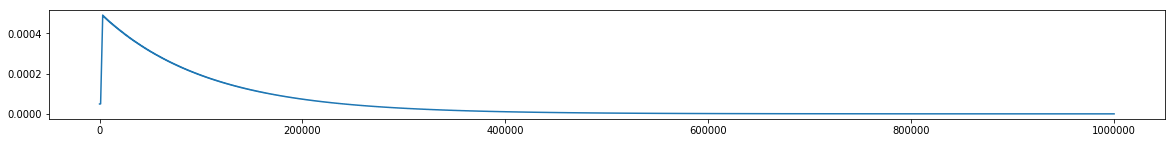

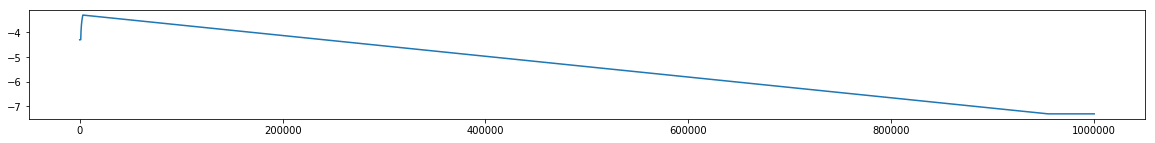

final learning rate:  5e-08


In [5]:
params['train_total_size'] = dataset_train.M
lr_schedule = tf.Session().run(learning_rate_schedule(params, tf.constant(np.arange(params['train_steps']))))
plt.figure(figsize=(20, 2))
plt.plot(lr_schedule)
plt.show()
plt.figure(figsize=(20, 2))
plt.plot(np.log10(lr_schedule))
plt.show()
print('final learning rate: ', lr_schedule[-1])

In [6]:
export_dir = os.path.join(data_dir, experiment, run_name, 'saved_model')
latest_export = sorted(os.listdir(export_dir))[-1]
predict_fn = tf.contrib.predictor.from_saved_model(os.path.join(export_dir, latest_export))

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


MAE: 8.878465650497663
AE_std: 8.847819362106359
AE_max: 66.1857557181151


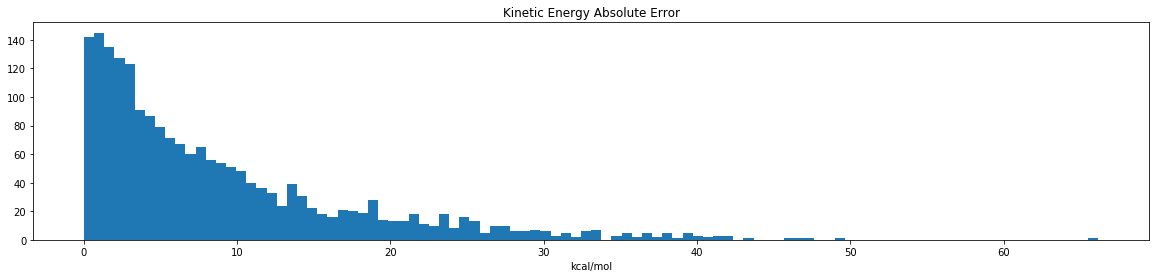

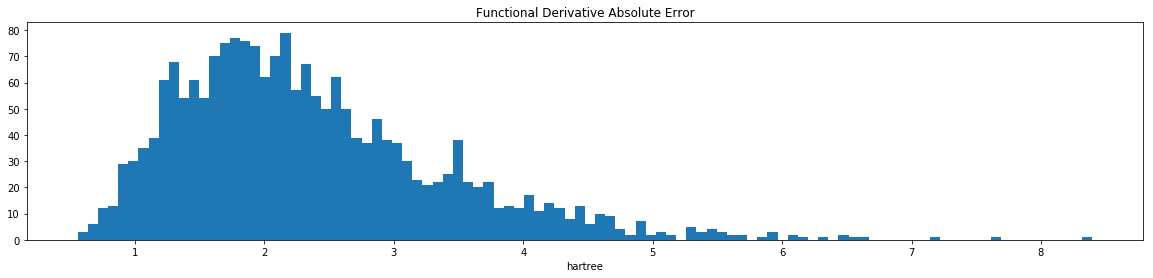

In [7]:
def plot_prediction_analysis(kenergies, derivatives, dataset):
    
    kenergies_err = np.abs(dataset.kenergies - kenergies)*kcalmol_per_hartree
    derivative_err = np.max(np.abs(dataset.derivatives - derivatives), axis=1)

    print('MAE:', np.mean(kenergies_err))
    print('AE_std:', np.std(kenergies_err))
    print('AE_max:', np.max(kenergies_err))

    plt.figure(figsize=(20, 4))
    plt.hist(kenergies_err, bins=100)
    plt.title('Kinetic Energy Absolute Error')
    plt.xlabel('kcal/mol')
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.hist(derivative_err, bins=100)
    plt.title('Functional Derivative Absolute Error')
    plt.xlabel('hartree')
    plt.show()

    
output = predict_fn({'features': dataset_eval.densities})
kenergies = output['value']
derivatives = output['derivative']
plot_prediction_analysis(kenergies, derivatives, dataset_eval)

### Test Time Data Augmentation

MAE: 8.810484283297944
AE_std: 8.756512674261666
AE_max: 56.56283777988268


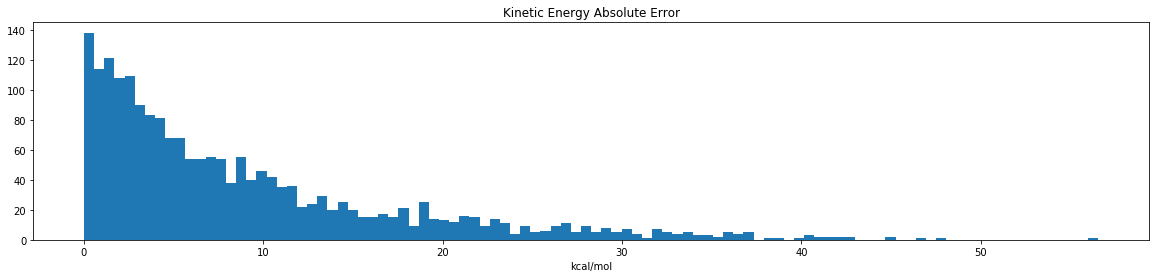

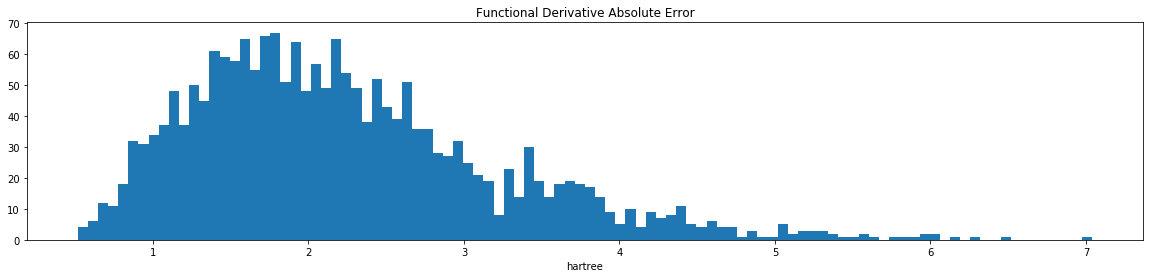

In [8]:
output_flip = predict_fn({'features': np.flip(dataset_eval.densities, axis=1)})
kenergies_flip = output_flip['value']
derivatives_flip = output_flip['derivative']

kenergies_augm = (kenergies + kenergies_flip)/2
derivatives_augm = (derivatives + np.flip(derivatives_flip, axis=1))/2

plot_prediction_analysis(kenergies_augm, derivatives_augm, dataset_eval)

Energy prediction:
5.719325215654155 5.6725197  = 29.37093927002432 kcal/mol


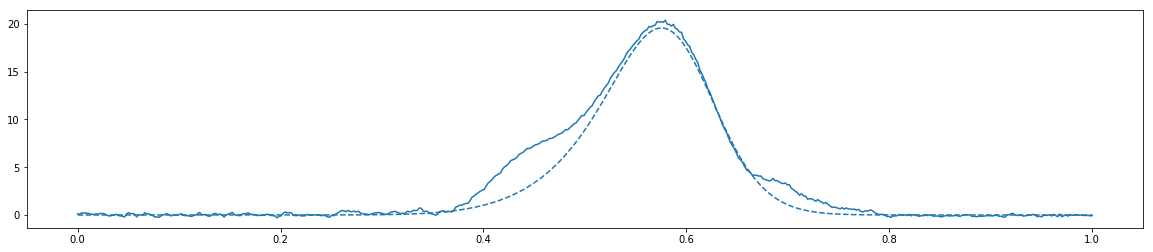

In [9]:
dataset_sample = InputPipeline(N=params['N'], dataset_file=os.path.join(data_dir, 'recreate_paper', 'dataset_sample.pkl'))

output = predict_fn({'features': dataset_sample.densities})
kinetic_energy_sample = output['value']
derivative_sample = output['derivative']

print('Energy prediction:')
print(dataset_sample.kenergies[0], kinetic_energy_sample[0], " =", np.abs(dataset_sample.kenergies[0]-kinetic_energy_sample[0])*kcalmol_per_hartree, "kcal/mol")

plt.figure(figsize=(20, 4))
plt.plot(dataset_sample.x, dataset_sample.derivatives[0], 'C0', linestyle='--')
plt.plot(dataset_sample.x, derivative_sample[0])
plt.show()

In [10]:
def deriv_conv_nn_model_fn_debug(features, labels, mode, params):
    
    if isinstance(features, dict):
        features = features['feature']

    target_prediction, layers = conv_nn(features, **params['kwargs'], return_layers=True)
    derivative_prediction = 1/params['h']*tf.gradients(target_prediction, features)[0]

    predictions = {
        'value': target_prediction,
        'derivative': derivative_prediction
    }
    
    for i, layer in enumerate(layers):
        predictions['layer' + str(i)] = layer
        
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        export_outputs={
        'regression': tf.estimator.export.PredictOutput(predictions)
        })

params['h'] = dataset_train.h
params['train_total_size'] = dataset_train.M
params['eval_total_size'] = dataset_eval.M
params['model_dir'] = os.path.join(data_dir, experiment, run_name)
params['batch_size'] = 1

model = tf.estimator.Estimator(
    model_fn=deriv_conv_nn_model_fn_debug,
    model_dir=params['model_dir'],
    params=params)

weights = {name:model.get_variable_value(name) for name in model.get_variable_names()}
results = next(model.predict(input_fn=dataset_sample.input_fn))
layers  = [results[key] for key in results.keys() if 'layer' in key]

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Energy prediction:
5.719325215654155 5.6725197  = 29.37093927002432 kcal/mol


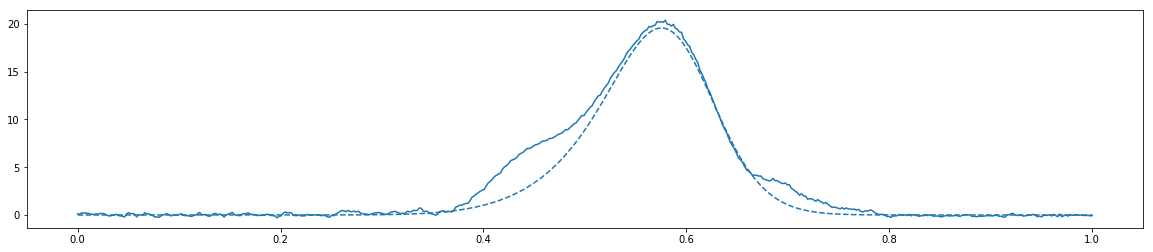

In [11]:
kinetic_energy_sample = output['value']
derivative_sample = output['derivative']

print('Energy prediction:')
print(dataset_sample.kenergies[0], kinetic_energy_sample[0], " =", np.abs(dataset_sample.kenergies[0]-kinetic_energy_sample[0])*kcalmol_per_hartree, "kcal/mol")

plt.figure(figsize=(20, 4))
plt.plot(dataset_sample.x, dataset_sample.derivatives[0], 'C0', linestyle='--')
plt.plot(dataset_sample.x, derivative_sample[0])
plt.show()

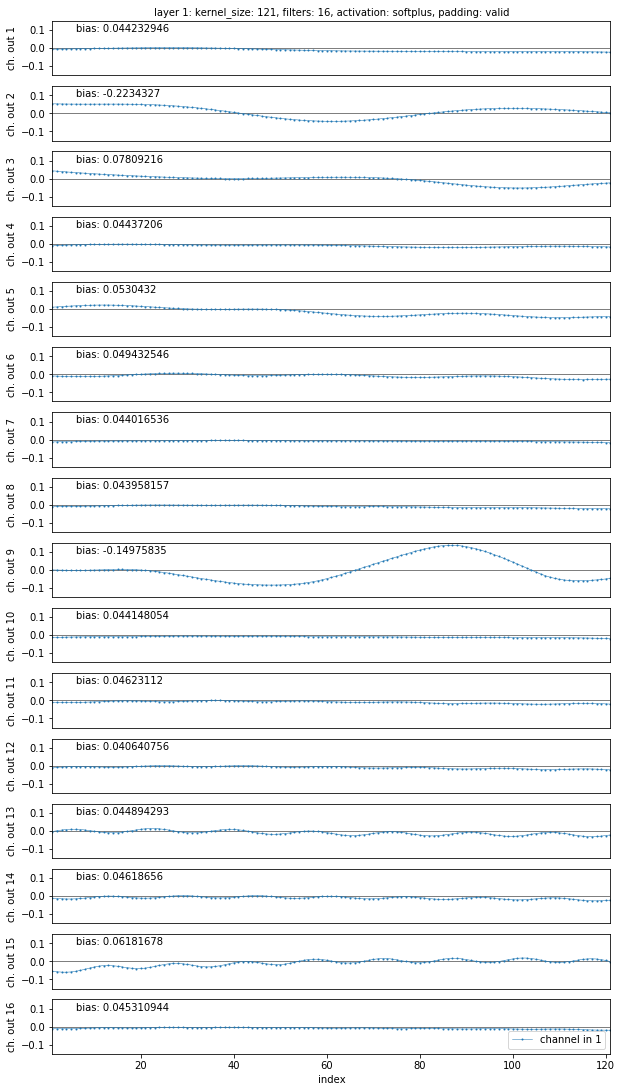

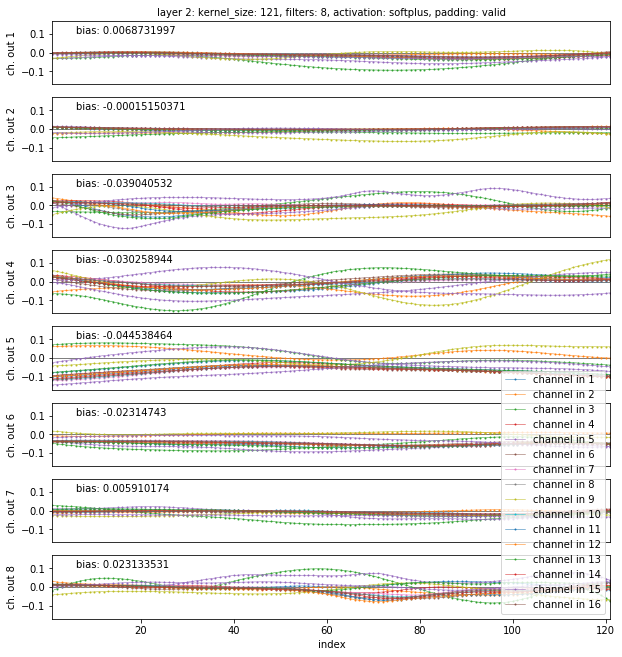

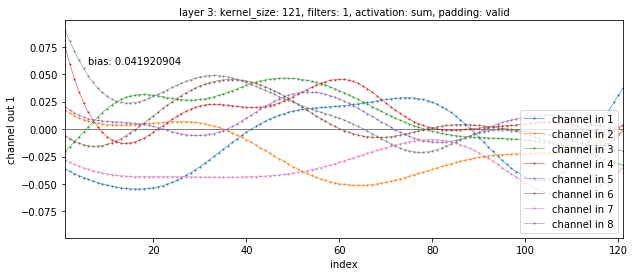

In [0]:
l = 1
for kernel, value in weights.items():
    if 'kernel' not in kernel or 'Adam' in kernel:
        continue
    
    #fig, axs = plt.subplots(value.shape[3], 1, figsize=(6, 2 + value.shape[3]), dpi=200)
    fig, axs = plt.subplots(value.shape[3], 1, figsize=(10, 3 + value.shape[3]))
    if value.shape[3] == 1:
        axs = [axs]
        
    limit = np.max(np.abs(value))*1.1
    
    for i, kern in enumerate(np.moveaxis(value, 3, 0)):
        axs[i].plot(np.arange(len(kern[:, 0]))+1, kern[:, 0], '.-', markersize=2, linewidth=0.5)
        axs[i].plot([1, len(kern[:, 0])], [0, 0], 'k', linewidth=0.5, zorder=-3)
        axs[i].text(6, limit*0.6, 'bias: ' + str(weights[kernel.replace('kernel', 'bias')][i]))
        axs[i].set_ylabel('ch{} out '.format('.' if value.shape[3] > 6 else 'annel') + str(i+1))
        axs[i].set_ylim([-limit, limit])
        axs[i].set_xlim([1, len(kern[:, 0])])
        
        if i == value.shape[3]-1: 
            axs[i].set_xlabel('index')
            axs[i].legend(['channel in ' + str(j+1) for j in range(kern.shape[2])], 
                          bbox_to_anchor=[1.0, 0.0], loc='lower right')
        else:
            axs[i].get_xaxis().set_visible(False)
        
        if i == 0:
            axs[i].set_title('layer {}: kernel_size: {}, filters: {}, activation: {}, padding: {}'.format(
            l, value.shape[0], value.shape[3], 'softplus' if l != 3 else 'sum', 'valid'), fontsize=10)
    l += 1

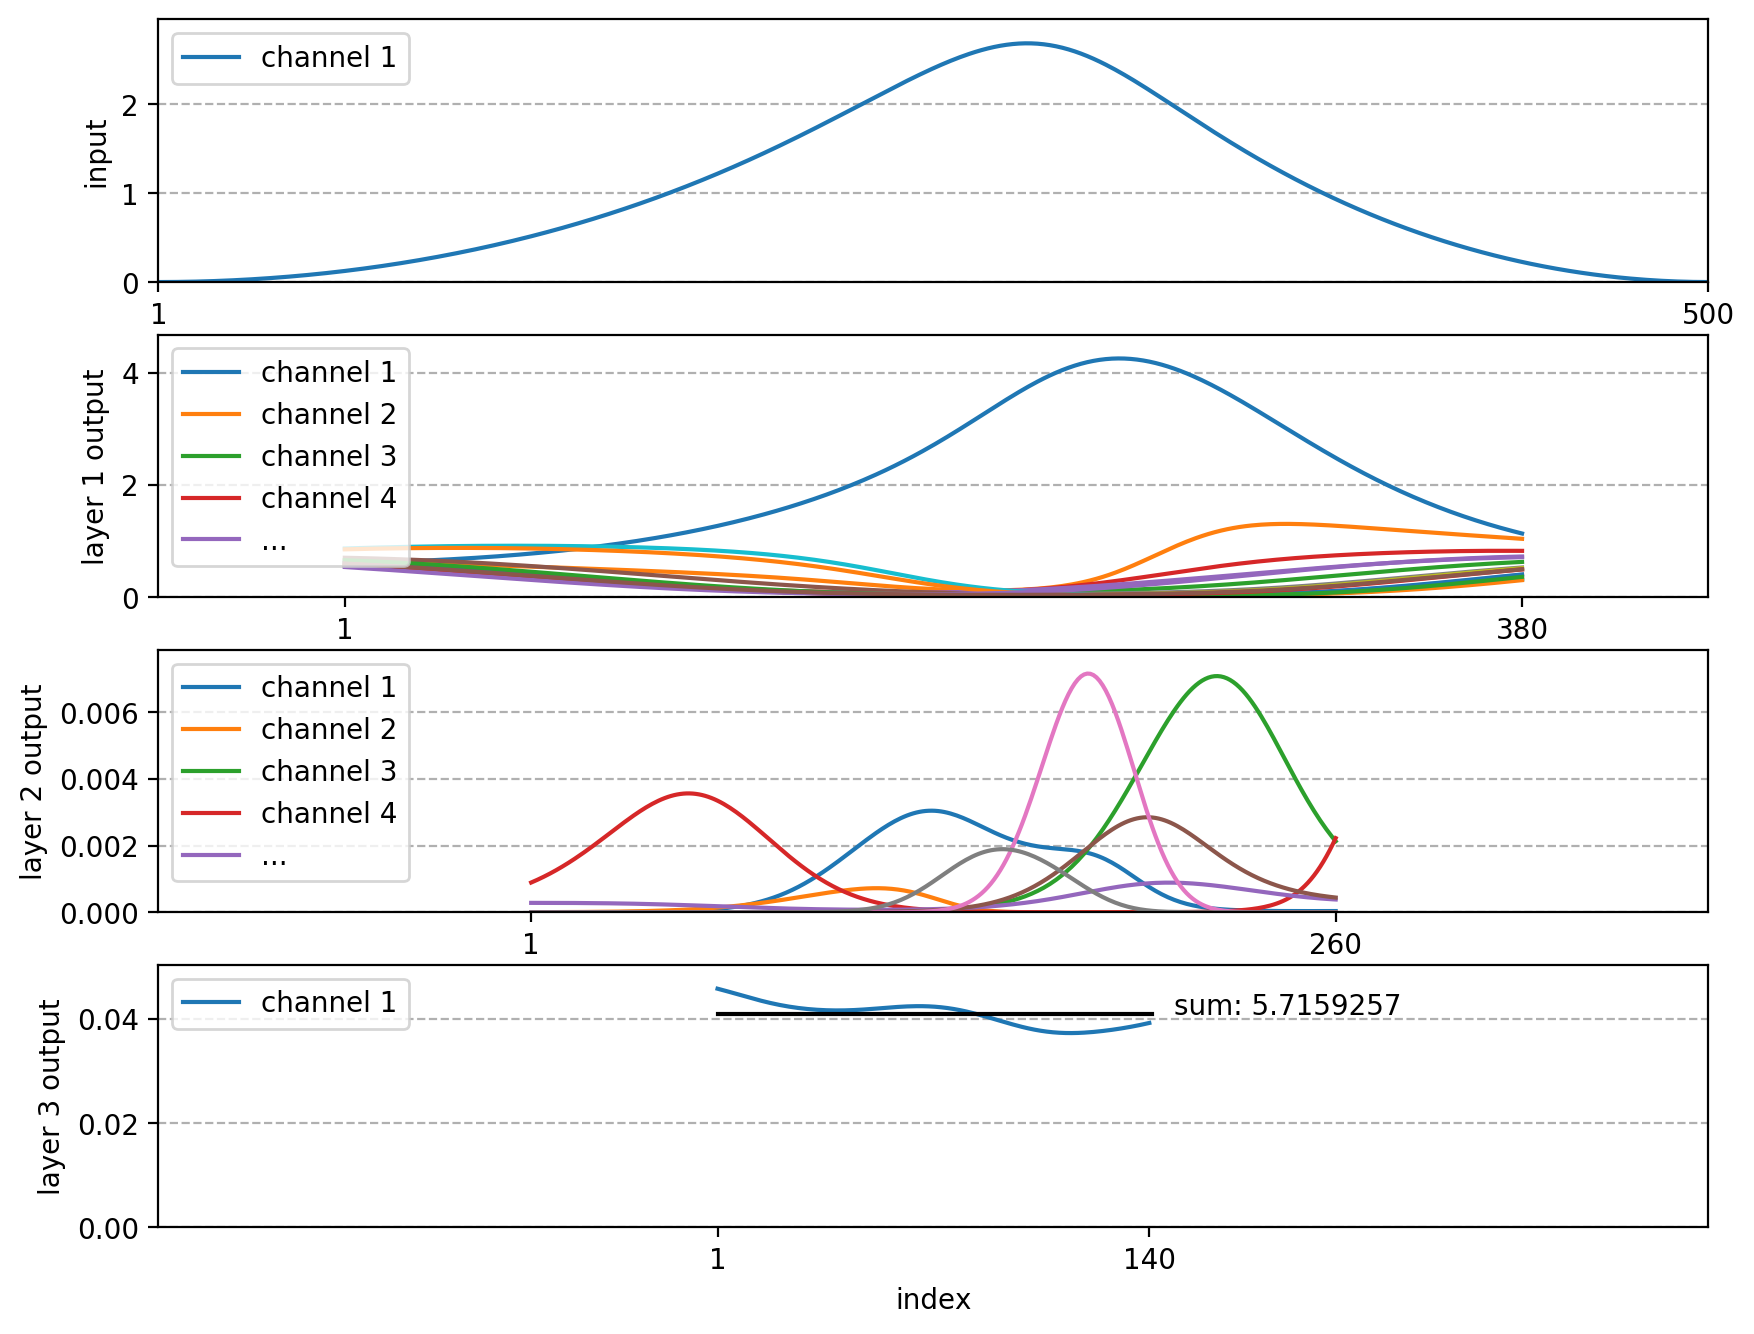

In [0]:
G = 500


#fig, axs = plt.subplots(value.shape[3], 1, figsize=(6, 2 + value.shape[3]), dpi=200)
fig, axs = plt.subplots(len(layers)-1, 1, figsize=(10, (len(layers)-1)*2), dpi=200)

for i, layer in enumerate(layers[:-1]):
        
    length = layer.shape[0]
    cutoff = (G - length)//2
    
    limit = np.max(np.abs(layer))*1.1

    axs[i].plot(np.arange(G-cutoff*2)+1, layer)#, '.-', markersize=2, linewidth=0.5)
    axs[i].set_ylim(0, limit)
    axs[i].set_xlim([-cutoff+1, G-cutoff])
    axs[i].grid(which='major', axis='y', linestyle='--')
    axs[i].set_xticks([1, length])
    
    if i == len(layers)-2:
        axs[i].plot([1, G-cutoff*2+1], np.ones(shape=(2,))*layers[-1]/length, 'k')
        axs[i].text(G-cutoff*2+8, layers[-1]/length, 'sum: ' + str(layers[-1]))
        axs[i].set_xlabel('index')
    axs[i].set_ylabel('layer ' + str(i) + ' output' if i > 0 else 'input')
    axs[i].legend(['channel ' + str(j+1) if j < 4 else '...' for j in range(layer.shape[1])][:5], loc='upper left')

# Ensemble

In [0]:
ensemble_run_names = ['seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9']

kcalmol_per_hartree = 627.51

params = load_hyperparameters(file_hyperparams, run_name=ensemble_run_names[0], globals=globals())

dataset_train = InputPipeline(params['N'], os.path.join(data_dir, params['dataset_train'], 'dataset_training.pkl'), is_training=True)
dataset_eval = InputPipeline(params['N'], os.path.join(data_dir, params['dataset_val'], 'dataset_validation.pkl'))

predict_fns = []

for run_name in ensemble_run_names:
    export_dir = os.path.join(data_dir, experiment, run_name, 'saved_model')
    latest_export = sorted(os.listdir(export_dir))[-1]
    predict_fns.append(tf.contrib.predictor.from_saved_model(os.path.join(export_dir, latest_export)))

def ensemble_predict_fn(features_dict):
    kenergies_n = []
    derivatives_n = []

    for predict_fn in predict_fns:
        output = predict_fn(features_dict)
        kenergies_n.append(output['value'])
        derivatives_n.append(output['derivative'])

    return {'value': np.mean(kenergies_n, axis=0), 'derivative': np.mean(derivatives_n, axis=0)}

MAE: 0.3083747423150856
AE_std: 0.21952942583033128
AE_max: 2.904298351171743


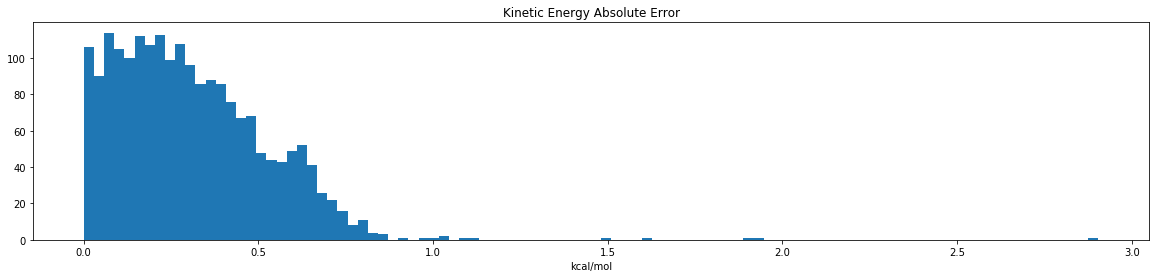

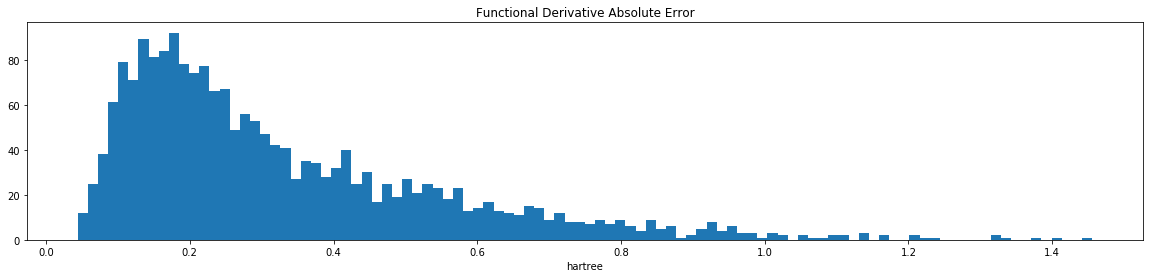

In [0]:
output = ensemble_predict_fn({'features': dataset_eval.densities})
kenergies_ens = output['value']
derivatives_ens = output['derivative']

plot_prediction_analysis(kenergies_ens, derivatives_ens, dataset_eval)

### Test Time Data Augmentation

MAE: 0.29920239051111397
AE_std: 0.20872299422862275
AE_max: 2.7971775606901756


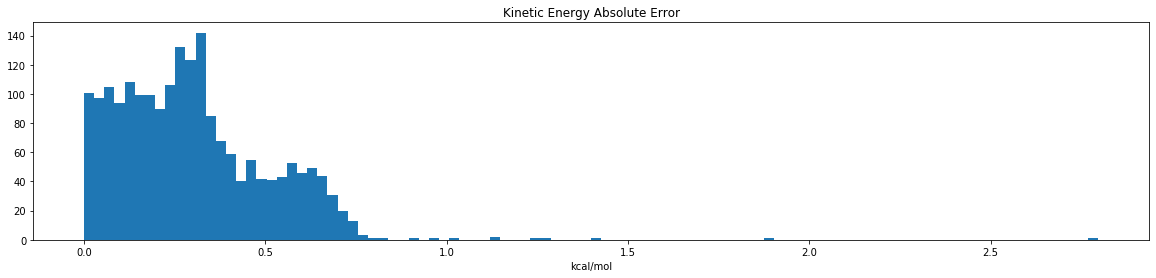

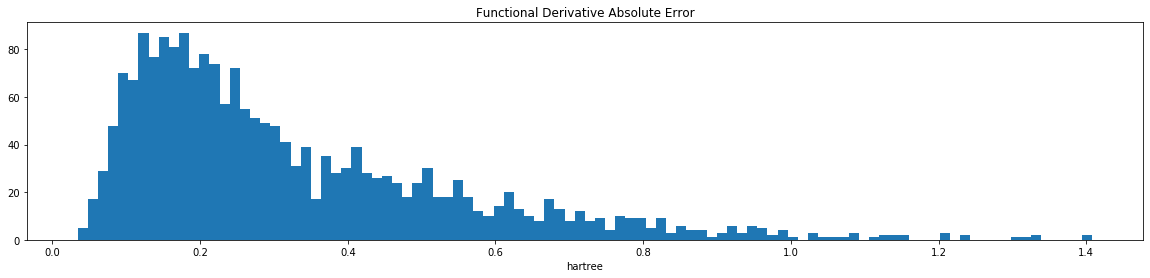

In [0]:
output = ensemble_predict_fn({'features': np.flip(dataset_eval.densities, axis=1)})
kenergies_ens_flip = output['value']
derivatives_ens_flip = output['derivative']

kenergies_ens_augm = (kenergies_ens + kenergies_ens_flip)/2
derivatives_ens_augm = (derivatives_ens + np.flip(derivatives_ens_flip, axis=1))/2

plot_prediction_analysis(kenergies_ens_augm, derivatives_ens_augm, dataset_eval)

Energy prediction:
5.719325215654155 5.718751  = 0.36035513496877597 kcal/mol


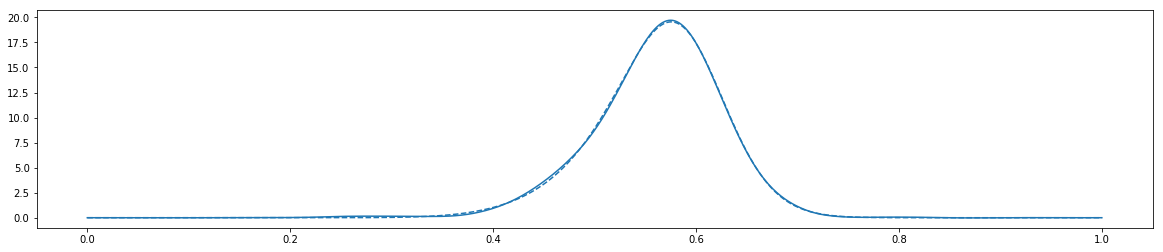

In [0]:
dataset_sample = InputPipeline(N=params['N'], dataset_file=os.path.join(data_dir, 'recreate_paper', 'dataset_sample.pkl'))

output = ensemble_predict_fn({'features': dataset_sample.densities})
kinetic_energy_sample = output['value']
derivative_sample = output['derivative']

print('Energy prediction:')
print(dataset_sample.kenergies[0], kinetic_energy_sample[0], " =", np.abs(dataset_sample.kenergies[0]-kinetic_energy_sample[0])*kcalmol_per_hartree, "kcal/mol")

plt.figure(figsize=(20, 4))
plt.plot(dataset_sample.x, dataset_sample.derivatives[0], 'C0', linestyle='--')
plt.plot(dataset_sample.x, derivative_sample[0])
plt.show()

In [0]:
def load_summaries(event_dir):
    import pandas as pd

    event_files = [file for file in os.listdir(event_dir) if '.tfevents' in file]

    values = {'wall_time': ([], [])}

    for event_file in event_files:
        for summary in tf.train.summary_iterator(os.path.join(event_dir, event_file)):
            if summary.summary.value.__len__() == 0: continue      

            if summary.step not in values['wall_time'][0]:
                values['wall_time'][0].append(summary.step)
                values['wall_time'][1].append(summary.wall_time)

            for entry in summary.summary.value:
                try:
                    if summary.step not in values[entry.tag][0]:
                        values[entry.tag][0].append(summary.step)
                        values[entry.tag][1].append(entry.simple_value)

                except KeyError:
                    values[entry.tag] = ([summary.step], [entry.simple_value])
                    
    for key in values.keys():        
        values[key] = pd.DataFrame(values[key][1], index=values[key][0], columns=[key])
    return values

In [0]:
summary_train = load_summaries(os.path.join(data_dir, experiment, run_name))
summary_eval = load_summaries(os.path.join(data_dir, experiment, run_name, 'eval'))
print(summary_train.keys(), summary_eval.keys())

dict_keys(['wall_time', 'loss', 'global_step/sec', 'examples/sec']) dict_keys(['wall_time', 'derivative_mae', 'loss', 'value_mae', 'checkpoint_path'])


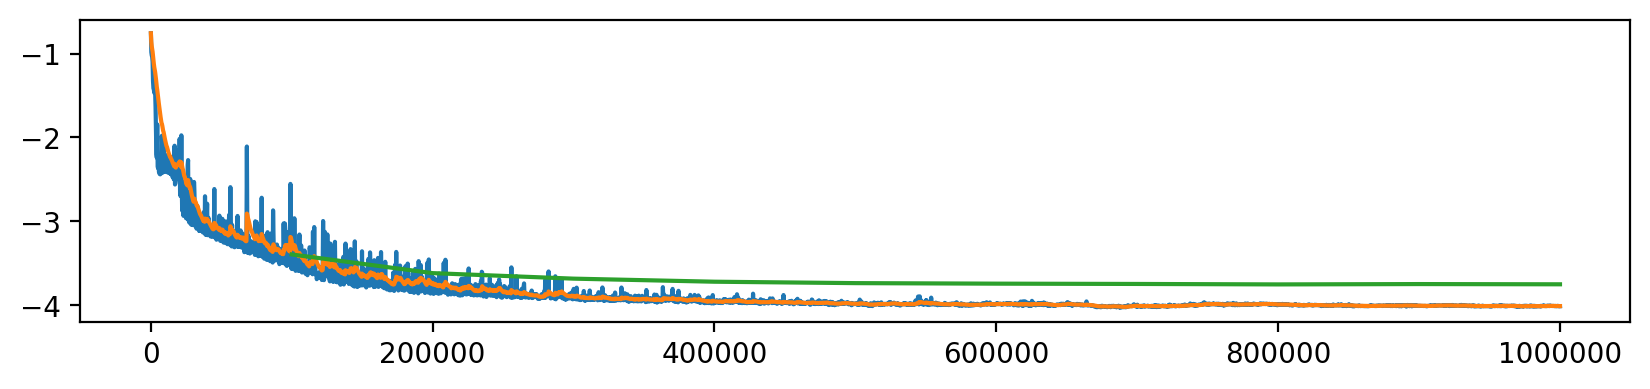

156.68028180835483 global_step/sec
15041.307049273395 examples/sec


In [0]:
plt.figure(figsize=(10, 2), dpi=200)
plt.plot(np.log10(summary_train['loss']))
plt.plot(np.log10(summary_train['loss'].ewm(com=10).mean()))
plt.plot(np.log10(summary_eval['loss']))
plt.show()

print(summary_train['global_step/sec'].mean()[0], 'global_step/sec')
print(summary_train['examples/sec'].mean()[0], 'examples/sec')

In [0]:
summary_train_ens = [load_summaries(os.path.join(data_dir, experiment, run_name)) for run_name in ensemble_run_names]
summary_eval_ens = [load_summaries(os.path.join(data_dir, experiment, run_name, 'eval')) for run_name in ensemble_run_names]

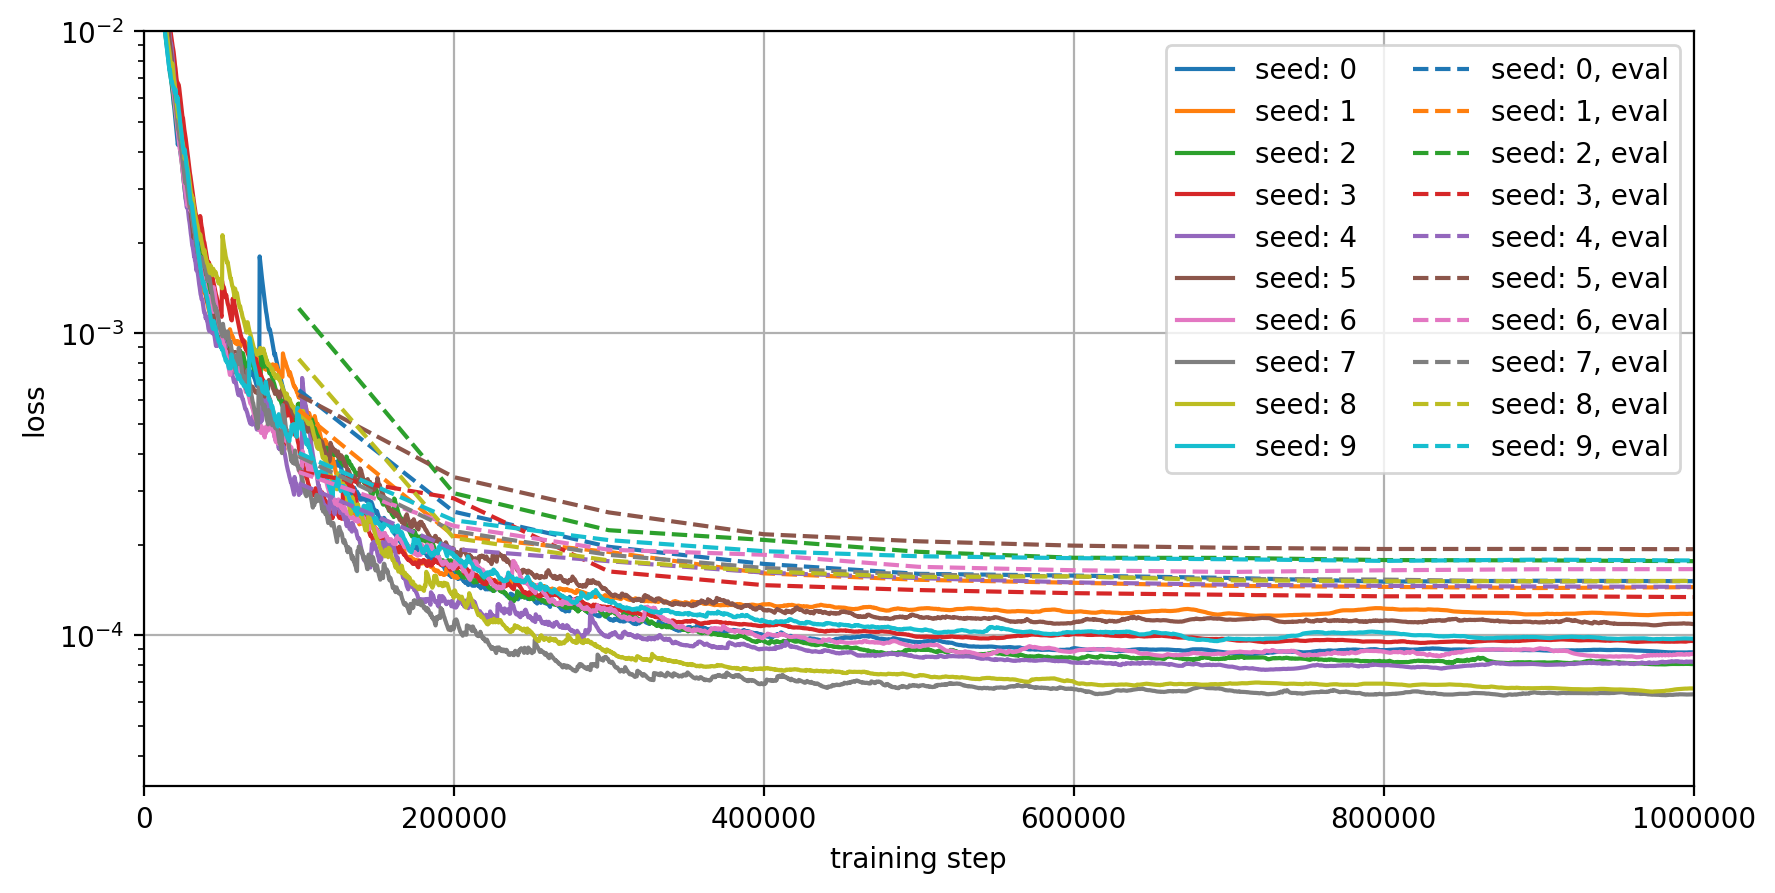

In [0]:
plt.figure(figsize=(10, 5), dpi=200)
for i, summary_e in enumerate(summary_train_ens): 
    plt.plot(summary_e['loss'].ewm(com=20).mean(), 'C' + str(i))
for i, summary_e in enumerate(summary_eval_ens): 
    plt.plot(summary_e['loss'], '--C' + str(i))

plt.yscale('log')
plt.ylim([10**(-4.5), 10**-2])
plt.xlim([0, 1000000])
plt.legend([name.replace('_', ': ') for name in ensemble_run_names] + [name.replace('_', ': ') + ', eval' for name in ensemble_run_names], ncol=2)
plt.grid()
plt.xlabel('training step')
plt.ylabel('loss')
plt.show()

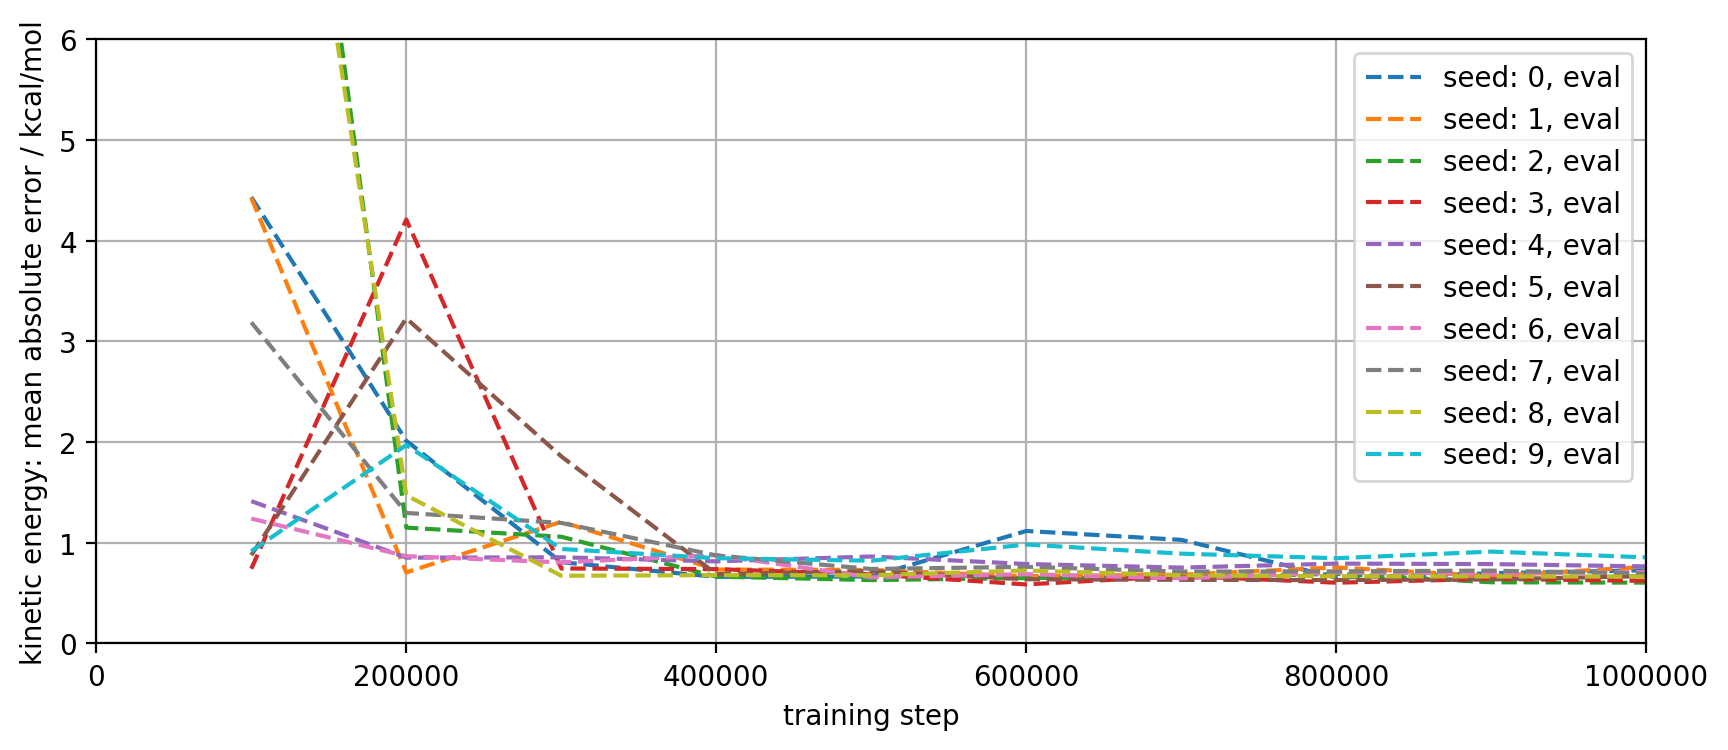

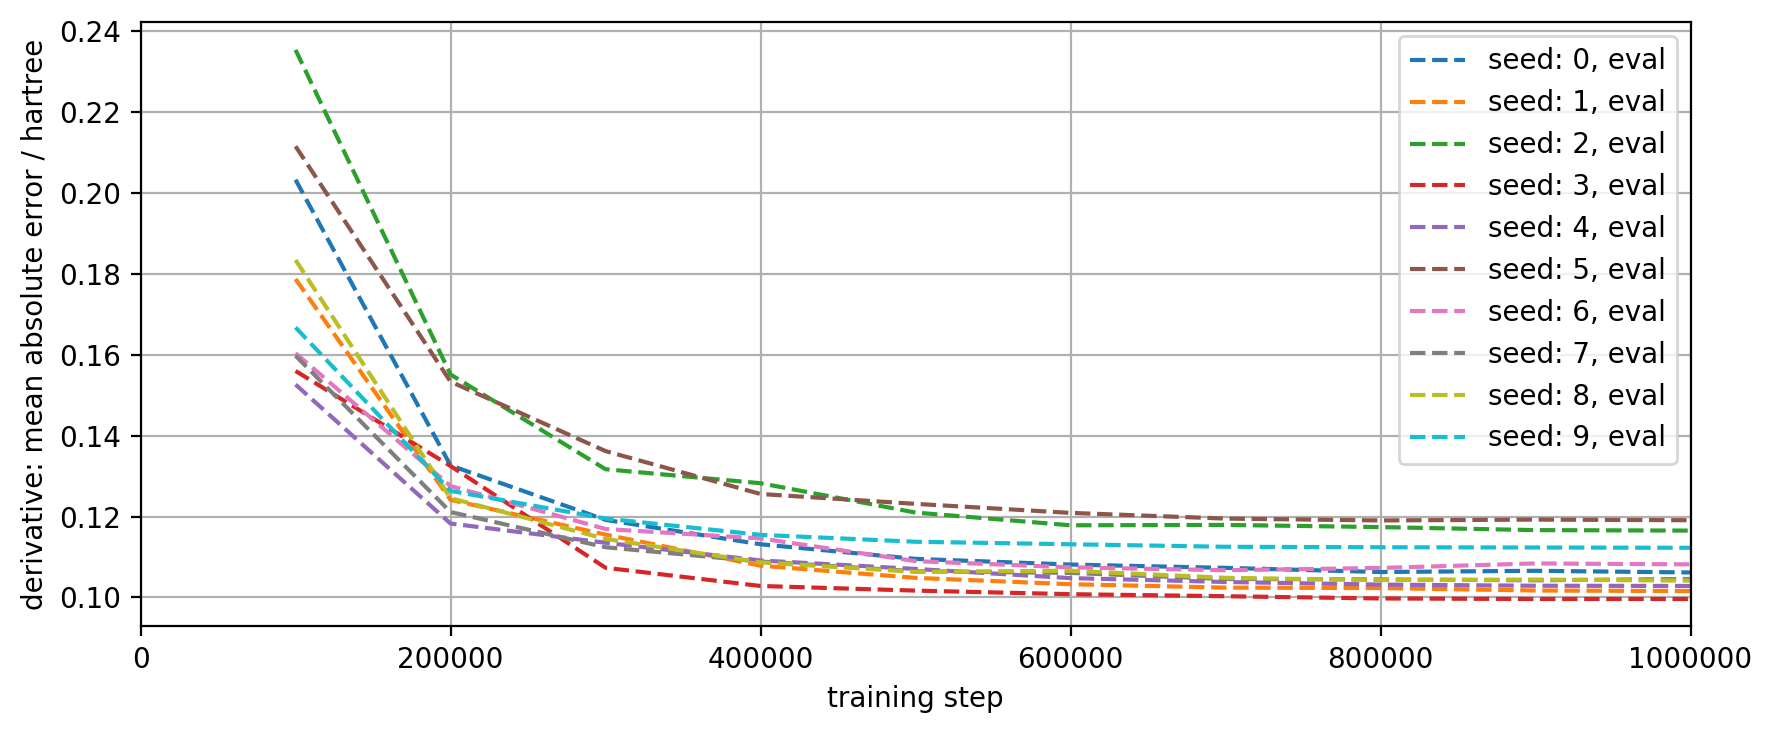

In [0]:
plt.figure(figsize=(10, 4), dpi=200)
for i, summary_e in enumerate(summary_eval_ens): 
    plt.plot(summary_e['value_mae']*kcalmol_per_hartree, '--C' + str(i))

#plt.yscale('log')
plt.ylim([0, 6])
plt.xlim([0, 1000000])
plt.legend([name.replace('_', ': ') + ', eval' for name in ensemble_run_names])
plt.grid()
plt.xlabel('training step')
plt.ylabel('kinetic energy: mean absolute error / kcal/mol')
plt.show()




plt.figure(figsize=(10, 4), dpi=200)
for i, summary_e in enumerate(summary_eval_ens): 
    plt.plot(summary_e['derivative_mae'], '--C' + str(i))

plt.xlim([0, 1000000])
plt.legend([name.replace('_', ': ') + ', eval' for name in ensemble_run_names])
plt.grid()
plt.xlabel('training step')
plt.ylabel('derivative: mean absolute error / hartree')
plt.show()